# Lyrics sentiment analysis and prediction using pyspark



This notebook file reads 2 CSV files, one with Songs lyricss and other with Songs classified by sentiments


In [1]:
!gdown 17Sc5B6-946GusvQB6O8nLXmFrnBbQ1Xg -O /content/sample_data/completes.csv
#https://drive.google.com/file/d/17Sc5B6-946GusvQB6O8nLXmFrnBbQ1Xg/view?usp=sharing


Downloading...
From: https://drive.google.com/uc?id=17Sc5B6-946GusvQB6O8nLXmFrnBbQ1Xg
To: /content/sample_data/completes.csv
100% 35.7M/35.7M [00:00<00:00, 43.0MB/s]


## Adding dependencies

In [2]:
!pip install pyspark

In [3]:
import math
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql import SQLContext
from IPython import display
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession

## Creating Spark context

In [4]:
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("test") \
        .config("spark.driver.memory", "5g")\
        .config("spark.executor.memory", "5g")\
        .config("spark.memory.offHeap.enabled", True)\
        .config("spark.memory.offHeap.size","2g")\
        .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

spark.sparkContext._conf.getAll()  # check the config

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[('spark.driver.port', '39583'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'),
 ('spark.driver.host', '62cd3da346e3'),
 ('spark.app.name', 'test'),
 

## Creating Schema for Emotions file

In [5]:
shcemaOutput = StructType([
    StructField("artist", StringType()),
    StructField("title", StringType()),
    StructField("seeds", StringType()),
    StructField("number_of_emotion_tags", StringType()),
    StructField("valence_tags", StringType()),
    StructField("arousal_tags", StringType()),
    StructField("dominance_tags", StringType()),
    StructField("genre", StringType()),
    StructField("year", StringType()),
    StructField("lyrics", StringType())
])

## Definition of files

In [6]:
#song_lyrics.csv file contains 3093218 songs data
outputFile = '/content/sample_data/completes.csv'

Reading CSV files for Emotions and Lyrics

In [7]:
innerJoin = sqlContext.read.format("csv").option("ignoreLeadingWhiteSpace", "true").option("multiline", "true").option('quote','"').option('escape', '"').option("header", "true").schema(shcemaOutput).load(outputFile)#.limit(10000)

## Preparing Data and new columns

In [8]:
innerJoin.show(truncate = 10)
innerJoin.count()

+----------+----------+----------+----------------------+------------+------------+--------------+----------+----+----------+
|    artist|     title|     seeds|number_of_emotion_tags|valence_tags|arousal_tags|dominance_tags|     genre|year|    lyrics|
+----------+----------+----------+----------------------+------------+------------+--------------+----------+----+----------+
|   Afroman|      Hush|['posit...|                     1|        7.57|         5.5|          7.26|   hip-hop|2000|[Hook] ...|
|Aimee Mann|    You Do|['smooth']|                    15|  5.51230...|  3.25753...|    5.47857...|singer-...|1999|[Verse ...|
|Air Supply|Even th...|['roman...|                     4|  7.42000...|      4.9625|    5.91166...| soft rock|1982|I, I wa...|
|Alice C...|      DaDa|['spooky']|                     1|         4.4|         6.0|          4.48|classic...|1983|Da Da\n...|
|Alicia ...|     Diary|['smooth']|                    14|  6.61333...|  3.94787...|    5.95272...|      soul|2004|[Ver

27349

In [9]:
innerJoin = innerJoin.withColumn("valence_tags", \
                     F.when(innerJoin.valence_tags.between(0, 4), 0)\
                     #.otherwise(F.when(innerJoin.valence_tags.between(2, 4), 1)\
                     #  .otherwise(F.when(innerJoin.valence_tags.between(4, 6), 2)\
                         .otherwise(F.when(innerJoin.valence_tags > 4, 1)))

In [10]:
innerJoin = innerJoin.withColumn("arousal_tags", \
                     F.when(innerJoin.arousal_tags.between(0, 4), 0)\
                     #.otherwise(F.when(innerJoin.arousal_tags.between(2, 4), 1)\
                     #  .otherwise(F.when(innerJoin.arousal_tags.between(4, 6), 2)\
                         .otherwise(F.when(innerJoin.arousal_tags  > 4, 1)))

In [11]:
innerJoin = innerJoin.withColumn("dominance_tags", \
                     F.when(innerJoin.dominance_tags.between(0, 2), 0)\
                     .otherwise(F.when(innerJoin.dominance_tags.between(2, 4), 1)\
                       .otherwise(F.when(innerJoin.dominance_tags.between(4, 6), 2)\
                         .otherwise(F.when(innerJoin.dominance_tags  > 6, 3)))))

In [12]:
categories = {'00':'Happy', '10':'Angry', '01':'Relaxed', '11':'Sad'}

innerJoin = innerJoin.withColumn('category', F.concat(F.col("valence_tags"), F.col('arousal_tags')))
innerJoin = innerJoin.replace(to_replace=categories, subset=['category'])

In [13]:
innerJoin.show(truncate = 10)

+----------+----------+----------+----------------------+------------+------------+--------------+----------+----+----------+--------+
|    artist|     title|     seeds|number_of_emotion_tags|valence_tags|arousal_tags|dominance_tags|     genre|year|    lyrics|category|
+----------+----------+----------+----------------------+------------+------------+--------------+----------+----+----------+--------+
|   Afroman|      Hush|['posit...|                     1|           1|           1|             3|   hip-hop|2000|[Hook] ...|     Sad|
|Aimee Mann|    You Do|['smooth']|                    15|           1|           0|             2|singer-...|1999|[Verse ...|   Angry|
|Air Supply|Even th...|['roman...|                     4|           1|           0|             2| soft rock|1982|I, I wa...|   Angry|
|Alice C...|      DaDa|['spooky']|                     1|           0|           1|             1|classic...|1983|Da Da\n...| Relaxed|
|Alicia ...|     Diary|['smooth']|                    1

In [14]:
from pyspark.sql.functions import col
innerJoin.groupBy("artist").count().orderBy(col("count").desc()).show()
innerJoin.groupBy("category").count().orderBy(col("count").desc()).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|           Bob Dylan|   82|
|        Warren Zevon|   76|
|They Might Be Giants|   74|
|     Robbie Williams|   73|
|            The Cure|   73|
|           Radiohead|   67|
|         The Beatles|   67|
|Manic Street Prea...|   63|
|       Chelsea Wolfe|   59|
|  The Mountain Goats|   59|
|         of Montreal|   58|
|           Kate Bush|   55|
|           Tori Amos|   54|
|       Elliott Smith|   53|
|    Barenaked Ladies|   53|
|         Bright Eyes|   52|
|   Animal Collective|   51|
|         Yo La Tengo|   51|
|      Regina Spektor|   50|
|       Kylie Minogue|   49|
+--------------------+-----+
only showing top 20 rows

+--------+-----+
|category|count|
+--------+-----+
|   Angry|12650|
|   Happy| 7065|
|     Sad| 5834|
| Relaxed| 1800|
+--------+-----+



## Model Pipeline

Spark Machine Learning Pipelines API is similar to Scikit-Learn. Our pipeline includes three steps:

regexTokenizer: Tokenization (with Regular Expression)

stopwordsRemover: Remove Stop Words

countVectors: Count vectors (“document-term vectors”)

In [15]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="lyrics", outputCol="words", pattern="[^a-zA-Z]")

# stop words
add_stopwords = []
add_stopwords.extend(stopwords.words('english'))
add_stopwords.extend(["verse","intro","chorus","rt","t","c","m","s","da","the"])

stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=5000, minDF=100)

In [17]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

label_stringIdx = StringIndexer(inputCol = "category", outputCol = "label")
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(innerJoin)
dataset = pipelineFit.transform(innerJoin)

In [18]:
#dataset.select("words", "filtered", "features", "label").orderBy(col("label").asc()).show(truncate=30)
dataset.select("filtered").orderBy(col("label").asc()).show(100, truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                            filtered|
+----------------------------------------------------------------------------------------------------+
|[mind, believe, maybe, forgive, rather, simply, run, getting, closer, time, cause, one, every, be...|
|[everything, must, end, every, romance, must, descend, every, lover, pact, decays, every, sad, mi...|
|[like, could, die, broken, heart, one, smile, could, fix, get, back, fall, believed, songs, sang,...|
|[lonely, one, wondering, went, wrong, love, gone, left, lonely, confused, feeling, like, used, ca...|
|[maybe, moonbeam, light, way, evening, comes, worry, care, bout, cold, outside, glad, wish, magic...|
|[told, could, give, life, would, leave, boundaries, mind, bet, never, even, knew, universe, insid...|
|[embody, spirit, motion, bodies, motion, bodies, motion, dig, ocean, swi

In [19]:
dataset.groupBy("label").count().orderBy(col("count").desc()).show()
dataset.count()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|12650|
|  1.0| 7065|
|  2.0| 5834|
|  3.0| 1800|
+-----+-----+



27349

In [20]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

window = Window.partitionBy(dataset['label']).orderBy(F.rand())
dataset = dataset.select(F.col('*'),
               F.row_number().over(window).alias('row_number')) \
               .where(F.col('row_number') <= 8000)

In [21]:
dataset.groupBy("label").count().orderBy(col("count").desc()).show()
dataset.count()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 8000|
|  1.0| 7065|
|  2.0| 5834|
|  3.0| 1800|
+-----+-----+



22699

## Partition Training & Test sets

In [22]:
# set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.8, 0.2])
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 18234
Test Dataset Count: 4465


## Model Training and Evaluation

Logistic Regression using Count Vector Features

Our model will make predictions and score on the test set; we then look at the top 10 predictions from the highest probability.

In [23]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0).select("filtered", "category","probability","label","prediction")\
.orderBy("probability", ascending=False).show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                      filtered|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|[skies, pure, fields, green...|   Happy|[0.9694407318178195,0.00281...|  1.0|       0.0|
|[take, river, take, river, ...|   Angry|[0.9674856953032704,0.02982...|  0.0|       0.0|
|[habit, taking, things, gra...|     Sad|[0.8991642497657686,0.02510...|  2.0|       0.0|
|[whenever, say, name, whene...|   Angry|[0.8702172906747242,0.02900...|  0.0|       0.0|
|[king, thirty, second, son,...|   Angry|[0.8656209004870342,0.03924...|  0.0|       0.0|
|[refrain, rolling, ball, ro...|   Angry|[0.859937330849136,0.014678...|  0.0|       0.0|
|[much, magnificence, near, ...|   Angry|[0.8023231158490091,0.06505...|  0.0|       0.0|
|[float, stream, rivers, dre...|   Angry|[0.7893974334429841,0.12614...|  0.0|       0.0|
|[walks, o

In [24]:
predictions.filter(predictions['prediction'] == 1).select("filtered", "category","probability","label","prediction")\
.orderBy("probability", ascending=False).show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                      filtered|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|[never, drank, nectar, kept...|     Sad|[0.4547050276888205,0.46174...|  2.0|       1.0|
|[well, feel, like, old, hob...|   Happy|[0.44546393158999753,0.4668...|  1.0|       1.0|
|[produced, hudson, mohawke,...|   Angry|[0.4356675709841977,0.45315...|  0.0|       1.0|
|[still, got, lot, learn, le...|   Angry|[0.41815509711235554,0.4823...|  0.0|       1.0|
|[today, crooked, highway, t...|   Happy|[0.41503317045828897,0.4312...|  1.0|       1.0|
|[sundown, dazzling, day, go...|   Angry|[0.4139393992721715,0.42676...|  0.0|       1.0|
|[shore, lake, great, upstat...|   Happy|[0.4110545566764927,0.47357...|  1.0|       1.0|
|[think, changed, think, sen...|   Angry|[0.4085386799917778,0.43847...|  0.0|       1.0|
|[bret, je

In [25]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
lrAccuracy = evaluator.evaluate(predictions)
print(lrAccuracy)

0.3841184178462623


## ROC curve
https://spark.apache.org/docs/latest/ml-classification-regression.html#multinomial-logistic-regression

https://spark.apache.org/docs/2.3.0/api/java/org/apache/spark/ml/classification/LogisticRegressionTrainingSummary.html

In [26]:
trainingSummary = lrModel.summary

# for multiclass, we can inspect metrics on a per-label basis
print("\nFalse positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nTrue positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nPrecision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("\nRecall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("\nF-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("\nAccuracy: %s\n\nFPR: %s\n\nTPR: %s\n\nF-measure: %s\n\nPrecision: %s\n\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))


False positive rate by label:
label 0: 0.3699500296434319
label 1: 0.24416017797552836
label 2: 0.07983751846381093
label 3: 0.001073409267100006

True positive rate by label:
label 0: 0.7076396452466158
label 1: 0.56657223796034
label 2: 0.39135066041755434
label 3: 0.07440273037542662

Precision by label:
label 0: 0.5100942126514132
label 1: 0.5101227482863064
label 2: 0.6295407813570939
label 3: 0.8582677165354331

Recall by label:
label 0: 0.7076396452466158
label 1: 0.56657223796034
label 2: 0.39135066041755434
label 3: 0.07440273037542662

F-measure by label:
label 0: 0.59284364205175
label 1: 0.5368677124402316
label 2: 0.48265895953757226
label 3: 0.13693467336683418

Accuracy: 0.5316441811999562

FPR: 0.2266653165498273

TPR: 0.5316441811999562

F-measure: 0.5105103312427773

Precision: 0.5688261171134309

Recall: 0.5316441811999562


## Logistic Regression using TF-IDF Features

In [27]:
from pyspark.ml.feature import HashingTF, IDF

hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=3000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx])

pipelineFit = pipeline.fit(innerJoin)
dataset = pipelineFit.transform(innerJoin)

(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+--------+------------------------------+-----+----------+
|category|                   probability|label|prediction|
+--------+------------------------------+-----+----------+
|   Angry|[0.9999999324239114,1.63463...|  0.0|       0.0|
| Relaxed|[0.9836629112177724,0.00202...|  3.0|       0.0|
|   Angry|[0.9702342613050158,0.00497...|  0.0|       0.0|
|   Happy|[0.9460180762755637,0.03676...|  1.0|       0.0|
|   Happy|[0.9381898734837107,0.01019...|  1.0|       0.0|
|     Sad|[0.9363316141983217,0.03109...|  2.0|       0.0|
|     Sad|[0.9356523603185324,0.02694...|  2.0|       0.0|
|   Angry|[0.9344038879965207,0.02503...|  0.0|       0.0|
|   Happy|[0.9090740540049982,0.07435...|  1.0|       0.0|
|     Sad|[0.8996252490286942,0.06735...|  2.0|       0.0|
+--------+------------------------------+-----+----------+
only showing top 10 rows



In [28]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.3929649948669445

In [29]:
from pyspark.sql.functions import row_number,lit
categoriess = {'1.0':'Happy', '0.0':'Angry', '3.0':'Relaxed', '2.0':'Sad'}
w = Window().orderBy(lit('A'))

In [30]:
predictions = predictions.withColumn('id', row_number().over(w))

classificationResults = predictions.select("id", "artist", "title", "lyrics", "category", "prediction")
classificationResults = classificationResults.withColumn("prediction", classificationResults["prediction"].cast(StringType()))\
                      .replace(to_replace=categoriess, subset=['prediction'])\
                      .withColumnRenamed("prediction", "p_Logistic_Regression")

#classificationResults = classificationResults.join(predictions, ["id"])
classificationResults.filter(classificationResults['artist'] == 'Eminem').show()


+----+------+---------------+--------------------+--------+---------------------+
|  id|artist|          title|              lyrics|category|p_Logistic_Regression|
+----+------+---------------+--------------------+--------+---------------------+
|2262|Eminem|        Bad Guy|Part 1: Produced ...|   Happy|                  Sad|
|2263|Eminem|Rhyme or Reason|[Intro: Sample + ...|   Angry|                Angry|
|2264|Eminem| So Much Better|[Intro]\nYou fuck...|   Angry|                  Sad|
|2265|Eminem|           Stan|[Produced by DJ M...|   Happy|                Angry|
|2266|Eminem|      The Sauce|[Intro]\nIt's all...| Relaxed|                Angry|
|2267|Eminem|         Tonite|[Produced by Mr. ...|   Happy|                Angry|
+----+------+---------------+--------------------+--------+---------------------+



## Naive Bayes

In [31]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1)
nbModel = nb.fit(trainingData)
predictions = nbModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("title","artist", "category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 50)

+------------------------+------------------------+--------+--------------------------------------------------+-----+----------+
|                   title|                  artist|category|                                       probability|label|prediction|
+------------------------+------------------------+--------+--------------------------------------------------+-----+----------+
|Bouncing Around the Room|                   Phish|   Angry|[1.0,1.0743274907381887E-16,7.26803033666939E-5...|  0.0|       0.0|
|          Laredo Tornado|Electric Light Orchestra|   Angry|[1.0,7.07751055759193E-17,2.871102246465088E-19...|  0.0|       0.0|
|  Brighter Than Sunshine|                Aqualung|   Angry|[1.0,6.65718909664867E-17,1.0596836415405972E-3...|  0.0|       0.0|
|             Tatted Lace|             Alela Diane|   Happy|[1.0,1.8487009211484072E-17,1.0303896426173514E...|  1.0|       0.0|
|                   Sorry|               The-Dream|   Happy|[1.0,1.1698893900820905E-17,1.3807411

In [32]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
nbAccuracy = evaluator.evaluate(predictions)
print(nbAccuracy)

0.4100831693736976


In [33]:
predictions = predictions.withColumn('id', row_number().over(w))

tmp = predictions.select("id", "prediction")
classificationResults = classificationResults.join(tmp, ["id"], )
classificationResults = classificationResults.withColumn("prediction", classificationResults["prediction"].cast(StringType()))\
                      .replace(to_replace=categoriess, subset=['prediction'])\
                      .withColumnRenamed("prediction", "p_Naive_Bayes")

classificationResults.filter(predictions['artist'] == 'Eminem').show()

+----+------+---------------+--------------------+--------+---------------------+-------------+
|  id|artist|          title|              lyrics|category|p_Logistic_Regression|p_Naive_Bayes|
+----+------+---------------+--------------------+--------+---------------------+-------------+
|2262|Eminem|        Bad Guy|Part 1: Produced ...|   Happy|                  Sad|          Sad|
|2263|Eminem|Rhyme or Reason|[Intro: Sample + ...|   Angry|                Angry|      Relaxed|
|2264|Eminem| So Much Better|[Intro]\nYou fuck...|   Angry|                  Sad|      Relaxed|
|2265|Eminem|           Stan|[Produced by DJ M...|   Happy|                Angry|        Angry|
|2266|Eminem|      The Sauce|[Intro]\nIt's all...| Relaxed|                Angry|      Relaxed|
|2267|Eminem|         Tonite|[Produced by Mr. ...|   Happy|                Angry|      Relaxed|
+----+------+---------------+--------------------+--------+---------------------+-------------+



## DecisionTreeClassifier

In [34]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(trainingData)
predictions = dtModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("title","artist","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+----------------+----------------+--------+------------------------------+-----+----------+
|           title|          artist|category|                   probability|label|prediction|
+----------------+----------------+--------+------------------------------+-----+----------+
|  Amaze Disgrace|               3|   Angry|[0.4924326319675157,0.21447...|  0.0|       0.0|
|Abandon All Hope|      Aesop Rock|   Happy|[0.4924326319675157,0.21447...|  1.0|       0.0|
|    All Mixed Up|             311|   Angry|[0.4924326319675157,0.21447...|  0.0|       0.0|
|  Electric Twist|   A Fine Frenzy|   Angry|[0.4924326319675157,0.21447...|  0.0|       0.0|
|     Hey Darling|     Ace of Base| Relaxed|[0.4924326319675157,0.21447...|  3.0|       0.0|
|             Pet|A Perfect Circle| Relaxed|[0.4924326319675157,0.21447...|  3.0|       0.0|
|      Postmortem|            1349| Relaxed|[0.4924326319675157,0.21447...|  3.0|       0.0|
|           Smile|             AFI|   Happy|[0.4924326319675157,0.2144

In [35]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
dtAccuracy = evaluator.evaluate(predictions)
print(dtAccuracy)

0.330970952654936


In [36]:
predictions = predictions.withColumn('id', row_number().over(w))

tmp = predictions.select("id", "prediction")
classificationResults = classificationResults.join(tmp, ["id"], )
classificationResults = classificationResults.withColumn("prediction", classificationResults["prediction"].cast(StringType()))\
                      .replace(to_replace=categoriess, subset=['prediction'])\
                      .withColumnRenamed("prediction", "p_Decision_Tree")

classificationResults.filter(predictions['artist'] == 'Eminem').show()

+----+------+---------------+--------------------+--------+---------------------+-------------+---------------+
|  id|artist|          title|              lyrics|category|p_Logistic_Regression|p_Naive_Bayes|p_Decision_Tree|
+----+------+---------------+--------------------+--------+---------------------+-------------+---------------+
|2262|Eminem|        Bad Guy|Part 1: Produced ...|   Happy|                  Sad|          Sad|          Angry|
|2263|Eminem|Rhyme or Reason|[Intro: Sample + ...|   Angry|                Angry|      Relaxed|            Sad|
|2264|Eminem| So Much Better|[Intro]\nYou fuck...|   Angry|                  Sad|      Relaxed|            Sad|
|2265|Eminem|           Stan|[Produced by DJ M...|   Happy|                Angry|        Angry|          Angry|
|2266|Eminem|      The Sauce|[Intro]\nIt's all...| Relaxed|                Angry|      Relaxed|          Angry|
|2267|Eminem|         Tonite|[Produced by Mr. ...|   Happy|                Angry|      Relaxed|         

## Random Forest

In [37]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)
# Train model with Training Data
rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("filtered","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                      filtered|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|[lost, lakes, shapes, body,...|   Angry|[0.47985174366815764,0.2639...|  0.0|       0.0|
|[see, view, way, trailing, ...|   Happy|[0.4787799144818327,0.26163...|  1.0|       0.0|
|[black, flies, windowsill, ...|   Angry|[0.47795582327083197,0.2553...|  0.0|       0.0|
|[fogs, silent, deadly, ghos...|   Angry|[0.4779047203866837,0.26051...|  0.0|       0.0|
|[comes, rainstorm, get, rub...|   Angry|[0.477792236109591,0.257977...|  0.0|       0.0|
|[ryan, miller, adam, gardne...|   Angry|[0.47777016348622026,0.2521...|  0.0|       0.0|
|[oh, say, shook, lost, summ...|   Angry|[0.4776267682258459,0.25800...|  0.0|       0.0|
|[love, summer, gone, eyes, ...|   Angry|[0.47743560549478914,0.2630...|  0.0|       0.0|
|[years, c

In [38]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
rfAccuracy = evaluator.evaluate(predictions)
print(rfAccuracy)

0.30228073087273916


In [39]:
predictions = predictions.withColumn('id', row_number().over(w))

tmp = predictions.select("id", "prediction")
classificationResults = classificationResults.join(tmp, ["id"], )
classificationResults = classificationResults.withColumn("prediction", classificationResults["prediction"].cast(StringType()))\
                      .replace(to_replace=categoriess, subset=['prediction'])\
                      .withColumnRenamed("prediction", "p_Random_Forest")

classificationResults.filter(predictions['artist'] == 'Eminem').show()

+----+------+---------------+--------------------+--------+---------------------+-------------+---------------+---------------+
|  id|artist|          title|              lyrics|category|p_Logistic_Regression|p_Naive_Bayes|p_Decision_Tree|p_Random_Forest|
+----+------+---------------+--------------------+--------+---------------------+-------------+---------------+---------------+
|2262|Eminem|        Bad Guy|Part 1: Produced ...|   Happy|                  Sad|          Sad|          Angry|          Angry|
|2263|Eminem|Rhyme or Reason|[Intro: Sample + ...|   Angry|                Angry|      Relaxed|            Sad|          Angry|
|2264|Eminem| So Much Better|[Intro]\nYou fuck...|   Angry|                  Sad|      Relaxed|            Sad|          Angry|
|2265|Eminem|           Stan|[Produced by DJ M...|   Happy|                Angry|        Angry|          Angry|          Angry|
|2266|Eminem|      The Sauce|[Intro]\nIt's all...| Relaxed|                Angry|      Relaxed|         

## OnevsRest classifer

In [40]:
from pyspark.ml.classification import LogisticRegression, OneVsRest

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

ovr = OneVsRest(classifier=lr)

ovrModel = ovr.fit(trainingData)

# score the model on test data.
predictions = ovrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("filtered","category","label","prediction") \
    .show(n = 10, truncate = 30)

+------------------------------+--------+-----+----------+
|                      filtered|category|label|prediction|
+------------------------------+--------+-----+----------+
|[think, help, wonder, yeste...|   Happy|  1.0|       0.0|
|[saw, came, evening, sighs,...|   Angry|  0.0|       0.0|
|[another, page, history, an...|   Angry|  0.0|       0.0|
|[remember, dessert, places,...|   Happy|  1.0|       0.0|
|[history, bluest, grace, fa...|   Angry|  0.0|       0.0|
|[digging, deeper, mind, get...|   Angry|  0.0|       0.0|
|[buck, drew, gustafson, aug...|   Happy|  1.0|       0.0|
|[well, cold, water, cold, s...|   Angry|  0.0|       0.0|
|[desert, landscape, continu...| Relaxed|  3.0|       0.0|
|[sure, suns, gonna, shine, ...|   Happy|  1.0|       0.0|
+------------------------------+--------+-----+----------+
only showing top 10 rows



In [41]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
ovrAccuracy = evaluator.evaluate(predictions)
print(ovrAccuracy)

0.37483801705761133


In [42]:
predictions = predictions.withColumn('id', row_number().over(w))

tmp = predictions.select("id", "prediction")
classificationResults = classificationResults.join(tmp, ["id"], )
classificationResults = classificationResults.withColumn("prediction", classificationResults["prediction"].cast(StringType()))\
                      .replace(to_replace=categoriess, subset=['prediction'])\
                      .withColumnRenamed("prediction", "p_One_vs_Rest")

classificationResults.filter(predictions['artist'] == 'Eminem').show()

+----+------+---------------+--------------------+--------+---------------------+-------------+---------------+---------------+-------------+
|  id|artist|          title|              lyrics|category|p_Logistic_Regression|p_Naive_Bayes|p_Decision_Tree|p_Random_Forest|p_One_vs_Rest|
+----+------+---------------+--------------------+--------+---------------------+-------------+---------------+---------------+-------------+
|2262|Eminem|        Bad Guy|Part 1: Produced ...|   Happy|                  Sad|          Sad|          Angry|          Angry|          Sad|
|2263|Eminem|Rhyme or Reason|[Intro: Sample + ...|   Angry|                Angry|      Relaxed|            Sad|          Angry|        Angry|
|2264|Eminem| So Much Better|[Intro]\nYou fuck...|   Angry|                  Sad|      Relaxed|            Sad|          Angry|          Sad|
|2265|Eminem|           Stan|[Produced by DJ M...|   Happy|                Angry|        Angry|          Angry|          Angry|        Angry|
|2266|

## Visualization

In [43]:
import matplotlib.pyplot as plt
import numpy as np
model = ['Logistic regression', 'Naive Bayes', 'Random Forest', 'OneVsRest']
accuracy = [lrAccuracy,nbAccuracy,rfAccuracy, ovrAccuracy]

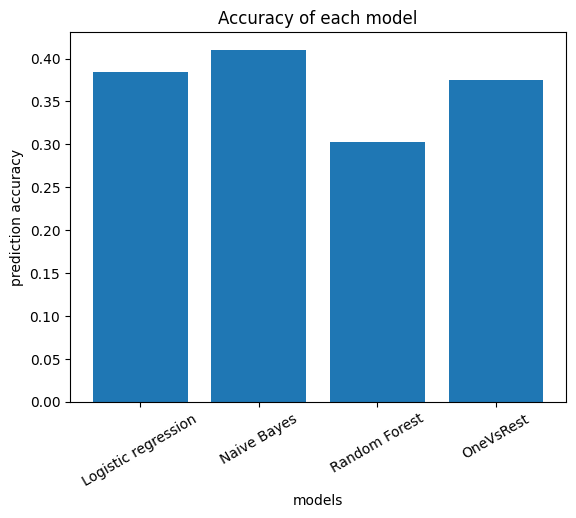

In [44]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(model))
    plt.bar(index, accuracy)
    plt.xlabel('models', fontsize=10)
    plt.ylabel('prediction accuracy', fontsize=10)
    plt.xticks(index, model, fontsize=10, rotation=30)
    plt.title('Accuracy of each model')
    plt.show()

plot_bar_x()

In [45]:
classificationResults.where(col('artist').like("E%")).show(5000)

+----+------+---------------+--------------------+--------+---------------------+-------------+---------------+---------------+-------------+
|  id|artist|          title|              lyrics|category|p_Logistic_Regression|p_Naive_Bayes|p_Decision_Tree|p_Random_Forest|p_One_vs_Rest|
+----+------+---------------+--------------------+--------+---------------------+-------------+---------------+---------------+-------------+
|2262|Eminem|        Bad Guy|Part 1: Produced ...|   Happy|                  Sad|          Sad|          Angry|          Angry|          Sad|
|2263|Eminem|Rhyme or Reason|[Intro: Sample + ...|   Angry|                Angry|      Relaxed|            Sad|          Angry|        Angry|
|2264|Eminem| So Much Better|[Intro]\nYou fuck...|   Angry|                  Sad|      Relaxed|            Sad|          Angry|          Sad|
|2265|Eminem|           Stan|[Produced by DJ M...|   Happy|                Angry|        Angry|          Angry|          Angry|        Angry|
|2266|